In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.preprocessing import sequence


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('spam.csv', encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df.rename(columns={'v1':'label', 'v2':'text'}, inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df.shape

(5572, 2)

In [16]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [13]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [14]:
temp = df.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,text
0,ham,4825
1,spam,747


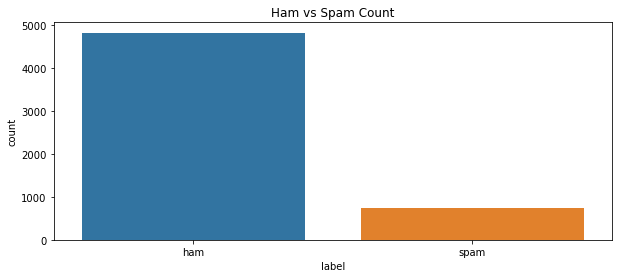

In [20]:
plt.figure(figsize=(10, 4))
plt.title('Ham vs Spam Count')
sns.countplot(x='label', data=df)
plt.show()

In [27]:
df['len'] = df['text'].apply(len)
before_total_words = df['len'].sum()
before_total_words

446422

In [21]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [22]:
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,label,text,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [26]:
df['cleaned_len'] = df['cleaned_text'].apply(len)
after_total_words = df['cleaned_len'].sum()
after_total_words

401860

In [29]:
print(f'total words reduced after basic removal = {before_total_words - after_total_words}')

total words reduced 44562


In [30]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [31]:
df['cleaned_text'] = df['cleaned_text'].apply(text_process)
df.head()

,label,text,cleaned_text,len,cleaned_len
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,111,102
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,29,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...,155,117
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,49,43
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,61,59


In [32]:
df['cleaned_len'] = df['cleaned_text'].apply(len)
after_total_words = df['cleaned_len'].sum()
after_total_words

269341

In [33]:
print(f'total words reduced after stop words removal = {before_total_words - after_total_words}')

total words reduced after stop words removal = 177081


In [48]:
df['temp_list'] = df['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,call,576
1,get,386
2,å£,293
3,go,278
4,ok,277
5,free,276
6,ltgt,276
7,know,257
8,like,242
9,got,238


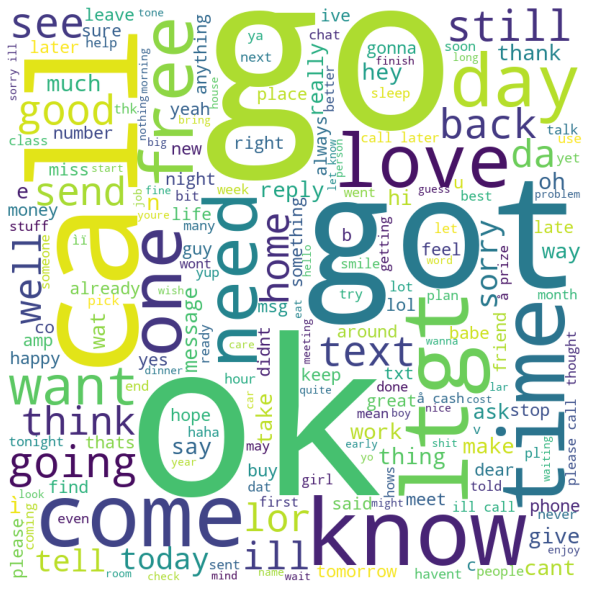

In [61]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)

full_text = ' '.join(text for text in df['cleaned_text'])
wordcloud.generate(full_text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [62]:
temp_list = df[df['label'] == 'ham']['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Greens')

,Common_words,count
0,get,303
1,ltgt,276
2,ok,272
3,go,247
4,ill,236
5,know,232
6,got,231
7,like,229
8,call,229
9,come,224


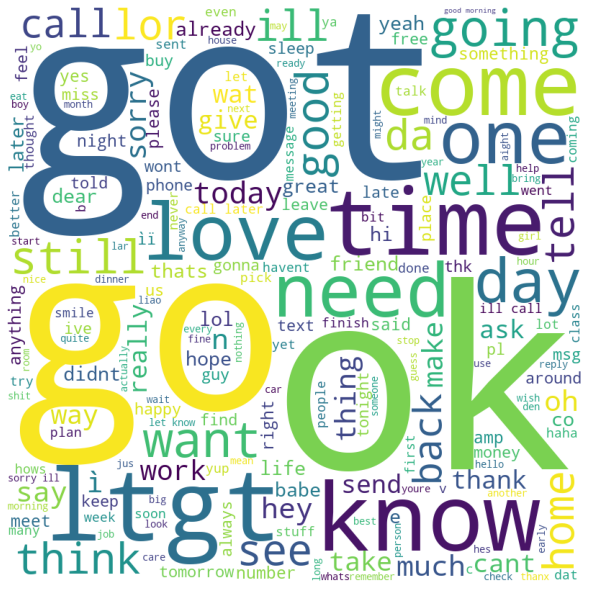

In [75]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)

full_text = ' '.join(' '.join(line) for line in temp_list.values)
wordcloud.generate(full_text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [76]:
temp_list = df[df['label'] == 'spam']['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Reds')

,Common_words,count
0,call,347
1,å£,289
2,free,217
3,txt,150
4,mobile,123
5,text,120
6,claim,113
7,stop,113
8,reply,101
9,prize,92


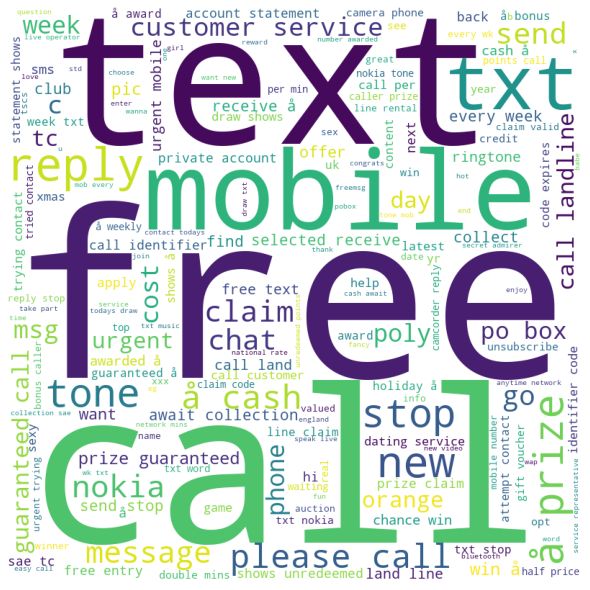

In [77]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)

full_text = ' '.join(' '.join(line) for line in temp_list.values)
wordcloud.generate(full_text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [78]:
lemmatizer = WordNetLemmatizer()

def lematizer(text):    
    return lemmatizer.lemmatize(text)


df['cleaned_text'] = df['cleaned_text'].apply(lematizer)
df.head()

,label,text,cleaned_text,len,cleaned_len,temp_list
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,111,82,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,29,21,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...,155,98,NaN
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,49,31,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,61,38,"[nah, think, goes, usf, lives, around, though]"


In [82]:
# Calculate the length of our vocabulary
from tensorflow.keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(df['cleaned_text'])

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

8098

In [83]:
X, y = df['cleaned_text'], df['label']

In [94]:
X[2]

'free entry wkly comp win fa cup final tkts may text fa receive entry questionstd txt ratetcs apply'

In [101]:
from tensorflow.keras.preprocessing.text import one_hot

In [104]:
# one hot representaion
X = X.apply(lambda x: one_hot(x, vocab_length))

In [113]:
max_sent_length = len(max(X.values, key=len))
max_sent_length

79

In [115]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [116]:
X = pad_sequences(X.values, padding='post',maxlen=max_sent_length)
X

array([[2353, 1607, 5358, ...,    0,    0,    0],
       [3558, 7256,  824, ...,    0,    0,    0],
       [4422, 5441, 3125, ...,    0,    0,    0],
       ...,
       [1560, 5587, 4654, ...,    0,    0,    0],
       [4842, 4336, 5239, ...,    0,    0,    0],
       [3602, 4352, 4835, ...,    0,    0,    0]])

In [122]:
y = y.map({'ham':0, 'spam':1})

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
# Creating model
embedding_vector_features = 150
model = Sequential()
model.add(Embedding(vocab_length, embedding_vector_features, input_length=max_sent_length))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 79, 150)           1214700   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               285696    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 1,566,445
Trainable params: 1,566,445
Non-trainable params: 0
___________________________________________

In [157]:
# Finally Training
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=128)

Epoch 1/20
35/35 [==============================] - 4s 47ms/step - loss: 0.3297 - accuracy: 0.8779 - val_loss: 0.1061 - val_accuracy: 0.9704
Epoch 2/20
35/35 [==============================] - 1s 20ms/step - loss: 0.0529 - accuracy: 0.9829 - val_loss: 0.0693 - val_accuracy: 0.9803
Epoch 3/20
35/35 [==============================] - 1s 20ms/step - loss: 0.0137 - accuracy: 0.9969 - val_loss: 0.0673 - val_accuracy: 0.9848
Epoch 4/20
35/35 [==============================] - 1s 20ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 0.0723 - val_accuracy: 0.9803
Epoch 5/20
35/35 [==============================] - 1s 20ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0824 - val_accuracy: 0.9803
Epoch 6/20
35/35 [==============================] - 1s 21ms/step - loss: 8.9941e-04 - accuracy: 0.9998 - val_loss: 0.0880 - val_accuracy: 0.9776
Epoch 7/20
35/35 [==============================] - 1s 20ms/step - loss: 3.7921e-04 - accuracy: 1.0000 - val_loss: 0.0979 - val_accuracy: 0.9803
Epoch

In [158]:
y_proba = model.predict(X_test)
y_pred = np.where(y_proba >= 0.5, 1, 0).flatten()
y_pred

array([1, 0, 1, ..., 0, 0, 1])

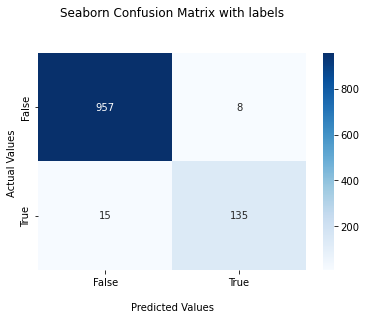

In [159]:
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='0')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [163]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.94      0.90      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [161]:
model.save('model.h5')